# EveryBeam OSKAR "MWA" integration tests

As `WODEN` has been heavily tested with the `MWA` beam, it makes sense to start by trying the replicate an `MWA` beam through `everybeam OSKAR`. We can do that by creating a measurement set with the `MWA` array layout and the tile configuration, and then just use the `OSKAR` dipole model to do the beam forming. This let's us compare results with known tested `hyperbeam` `MWA_FEE`. Should be good enough to check we have the right sign conventions, and things look sensible on the sky.

To see how the `OSKAR-MWA` measurement set was created, see the `WODEN/test_installation/everybeam/create_OSKAR-MWA_ms/make_oskar-mwa_beam.ipynb` notebook.

Goes without saying, but the test here rely on `everybeam` being installed.

In [3]:
import sys
##This is to get hold of EveryBeam on my machine
sys.path.append('/home/jline/software/installed/lib/python3.12/site-packages')
import os
from subprocess import call
from astropy.io import fits
import numpy as np
from astropy.table import Column, Table
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy import units as u
import matplotlib.pyplot as plt
import numpy.testing as npt
from astropy.constants import c
from astropy.wcs import WCS
import everybeam as eb
from wodenpy.primary_beam.use_everybeam import load_MWA_telescope, load_OSKAR_telescope, load_LOFAR_telescope, run_everybeam, radec_to_xyz, run_everybeam_over_threads
import erfa
import mwa_hyperbeam
from wodenpy.skymodel.read_fits_skymodel import calc_everybeam_for_components
from wodenpy.use_libwoden.create_woden_struct_classes import Woden_Struct_Classes
from ctypes import c_double
from astropy.time import TimeDelta
from wodenpy.array_layout.precession import RTS_Precess_LST_Lat_to_J2000

import sys
sys.path.append('../../scripts/')
from run_woden import main as run_woden

##A bunch of test and plotting code lives here so we can use it in multile notebooks
from eb_testing_code import create_WCS, plot_jones_on_sky, plot_everybeam_on_sky, make_sky_models, read_uvfits, convert_inst_to_stokes, test_stokes_recovery, getFDF, findpeaks, test_RM_recovery, make_RM_skymodel

os.environ["MWA_BEAM_FILE"] = "/home/jline/software/MWA_beam_files/mwa_full_embedded_element_pattern.h5"

C = c.to('m/s').value

# ra0 = 0.0
# dec0 = -26.7
MWA_LAT=-26.703319405555554
MWA_LONG=116.67081523611111

##pick a time/date that sticks our phase centre overhead
date = "2024-07-21T20:13:00"
##Assume that the OSKAR telescope is near the MWA??
mwa_location = EarthLocation(lat=MWA_LAT*u.deg, 
                            lon=MWA_LONG*u.deg,
                            height=377.827)
observing_time = Time(date, scale='utc', location=mwa_location)

##Grab the LST
LST = observing_time.sidereal_time('mean')
LST_deg = LST.value*15
# print(f"LST: {LST_deg} deg, RA: {ra0}")

## What does the beam look like on the sky?

First up, let's plot the `hyperbeam` `MWA_FEE` beam model on the sky to see what we're expecting

/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


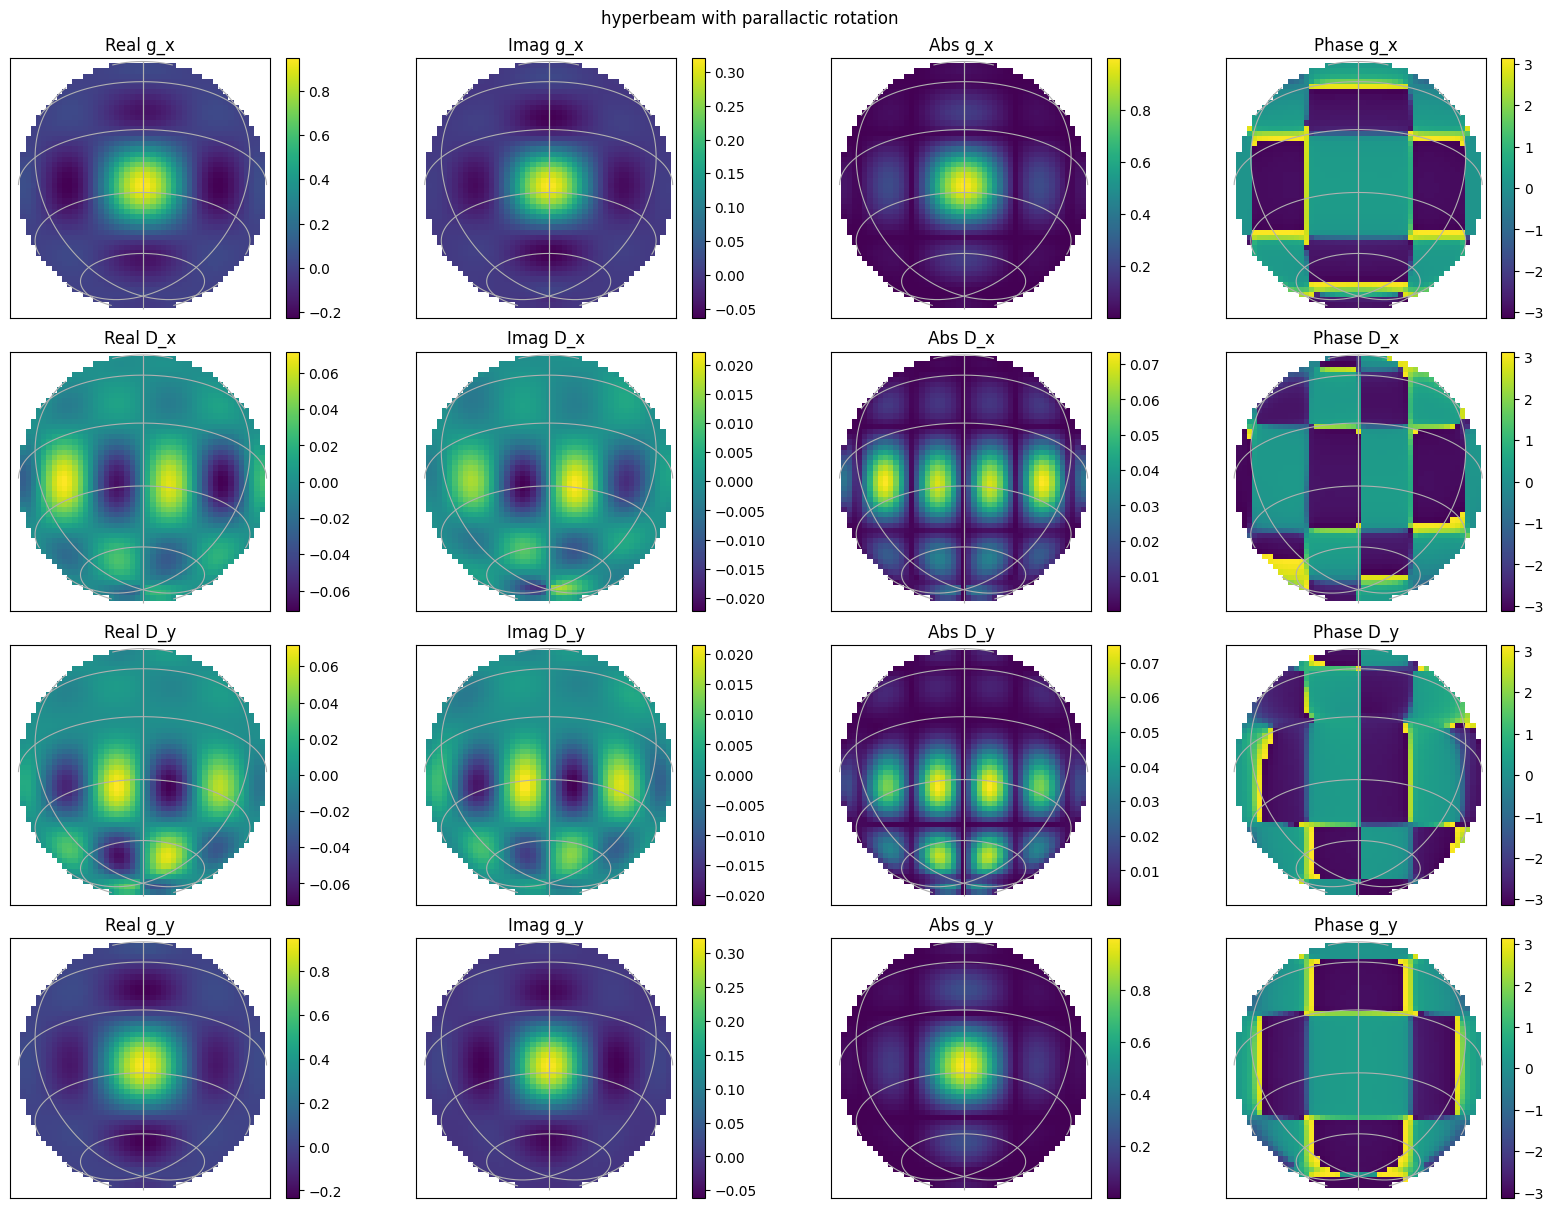

In [4]:
##Set up a grid of RA, Dec points

ra0 = LST_deg
dec0 = MWA_LAT

mjd_current = observing_time.mjd
lst_J2000, latitude_J2000 = RTS_Precess_LST_Lat_to_J2000(np.radians(LST_deg),
                                                         np.radians(MWA_LAT),
                                                         mjd_current)

nside=50
radec_reso=120/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = np.radians(ras.flatten())
decs = np.radians(decs.flatten())

##Then use erfa to convert these values into azs, els
# has = np.radians(LST_deg) - ras
has = lst_J2000 - ras

##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here
az_grid, els = erfa.hd2ae(has, decs, latitude_J2000)
za_grid = np.pi/2 - els

##mwa hyperbeam
beam = mwa_hyperbeam.FEEBeam()

freq = 160e+6

parallactic_rotation = True
IAU_order = True

jones = beam.calc_jones_array(az_grid, za_grid, freq, [0]*16, [1]*16,
                              IAU_order, latitude_J2000, parallactic_rotation)

all_gx_hyp = jones[:,0]
all_Dx_hyp = jones[:,1]
all_Dy_hyp = jones[:,2]
all_gy_hyp = jones[:,3]

all_gx_hyp.shape = (nside, nside)
all_Dx_hyp.shape = (nside, nside)
all_Dy_hyp.shape = (nside, nside)
all_gy_hyp.shape = (nside, nside)

plot_jones_on_sky(all_gx_hyp, all_Dx_hyp, all_Dy_hyp, all_gy_hyp, wcs, title="hyperbeam with parallactic rotation")

Do a sanity check that we have polarisations in the order that we want. North dipoles are most sensitive towards the East-West, so if we subtract Y from X, we should see a positive signal towards the East-West, and negative towards the North-South.

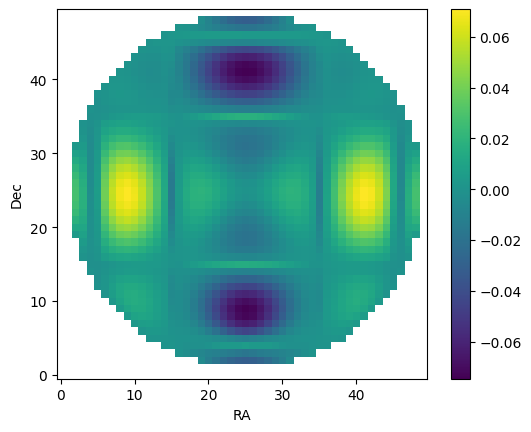

In [5]:
diff = np.abs(all_gx_hyp) - np.abs(all_gy_hyp)
im = plt.imshow(diff, origin='lower')
plt.colorbar(im)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.show()

Next, let's do the equivalent for the `everybeam` `OSKAR` "MWA" beam model and see how it compares. We'll ask `EveryBeam` to do the parallactic rotation for us

Thread 0 processing coords 0 to 313Thread 4 processing coords 1252 to 1565

Thread 2 processing coords 626 to 939Thread 3 processing coords 939 to 1252Thread 5 processing coords 1565 to 1878


Thread 7 processing coords 2191 to 2504
Thread 1 processing coords 313 to 626
Thread 6 processing coords 1878 to 2191


/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:4642: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:4642: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:19026: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:19026: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:4642: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:19026: RuntimeWarning: invali

Thread 3 finishedThread 4 finished

Thread 7 finished
Thread 2 finished
Thread 6 finished
Thread 5 finished
Thread 1 finished
Thread 0 finished


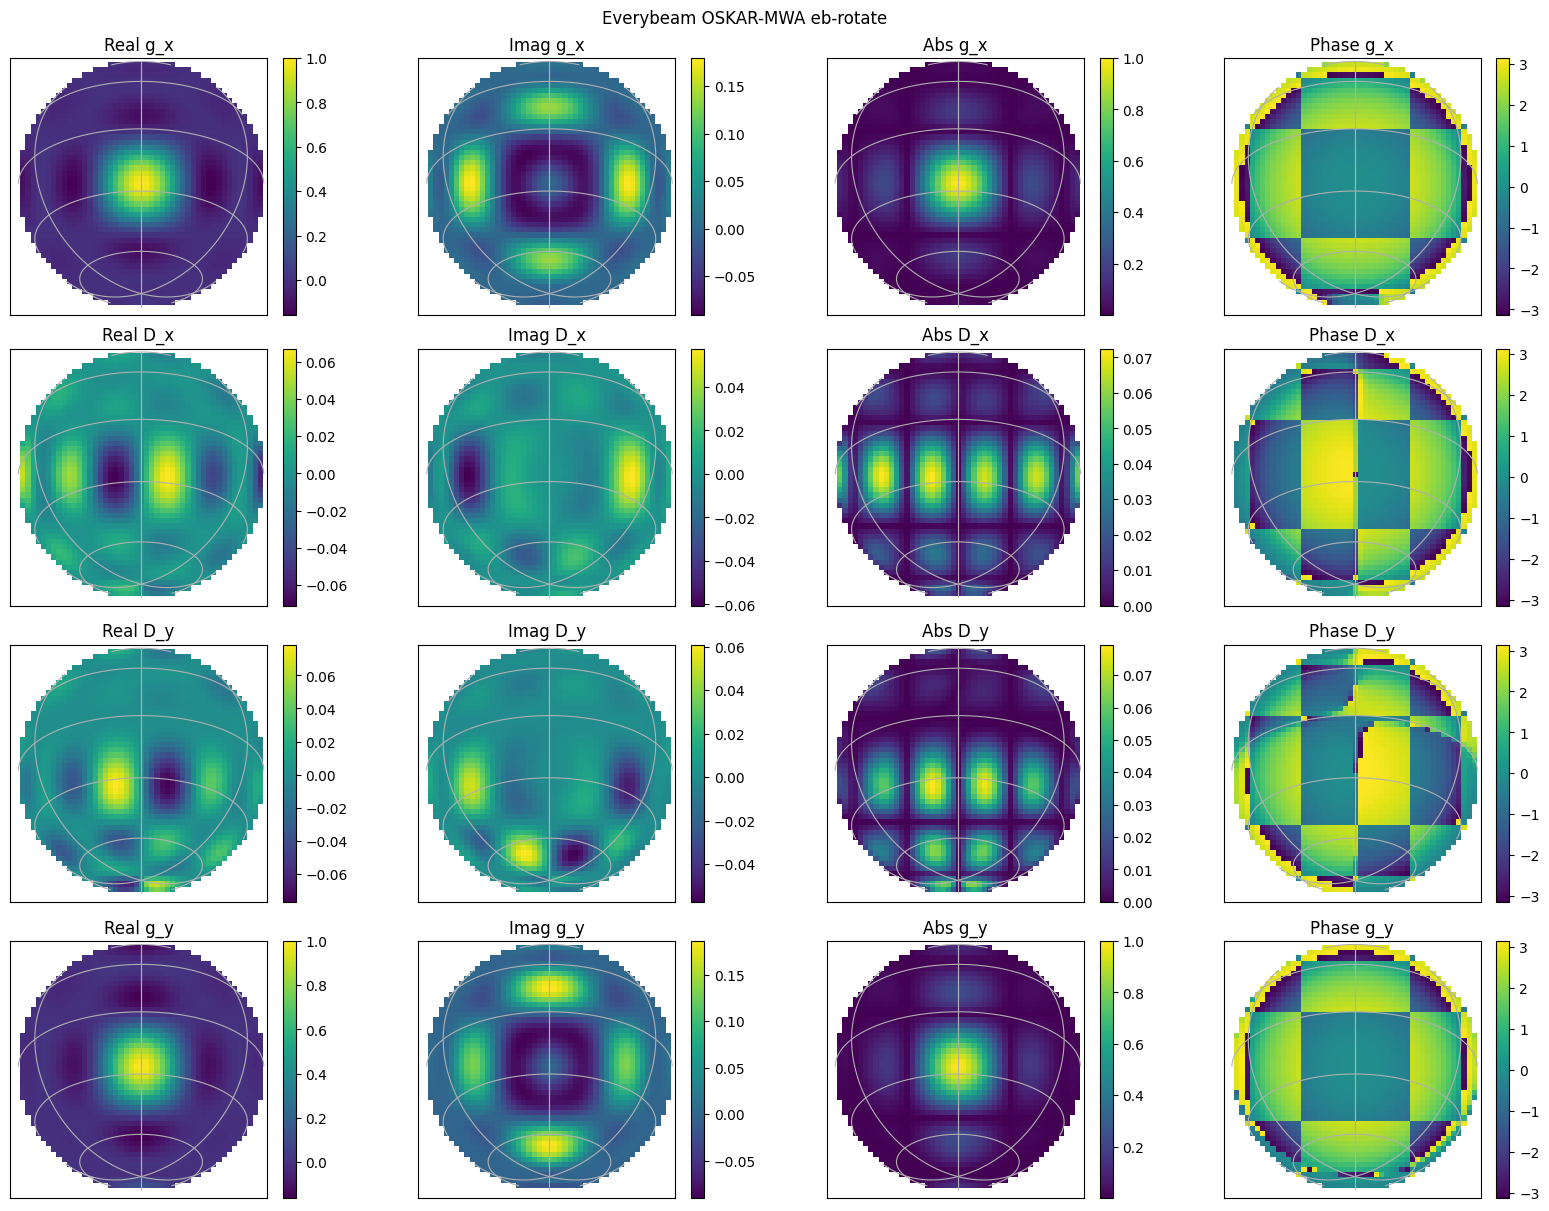

In [6]:
##I made the measurement set using OSKAR with the MWA layout
ms_path="create_OSKAR-MWA_ms/OSKAR-MWA-layout.ms"
coeff_path=""
station_id = 0
station_ids = [0]
j2000_latitudes = [latitude_J2000]
j2000_lsts = [lst_J2000]
times = [observing_time]
freqs = [freq]
current_latitude = np.radians(MWA_LAT)
current_longitude = np.radians(MWA_LONG)

apply_beam_norms=True
use_differential_beam=False

##We need to turn on parallactic rotation in wodenpy as it doesn't exist for
##EveryBeam MWA. We also need to reorder the jones to get north-south first
parallactic_rotate=False
reorder_jones=False
eb_rotate = True

element_response = "skala40_wave"

##How many cores to split the work over
num_threads=8

# telescope = load_OSKAR_telescope(ms_path)

all_jones = run_everybeam_over_threads(num_threads, ms_path,
                            coeff_path,
                            ras, decs,
                            np.radians(ra0), np.radians(dec0),
                            j2000_latitudes, j2000_lsts,
                            current_latitude, current_longitude,
                            times, freqs, station_ids,
                            use_differential_beam=use_differential_beam,
                            apply_beam_norms=apply_beam_norms,
                            reorder_jones=reorder_jones,
                            parallactic_rotate=parallactic_rotate,
                            element_response_model=element_response,
                            eb_rotate=eb_rotate)

beam_ind, time_ind, freq_ind = 0, 0, 0

all_gx_eb = all_jones[beam_ind, time_ind, freq_ind, :, 0, 0]
all_Dx_eb = all_jones[beam_ind, time_ind, freq_ind, :, 0, 1]
all_Dy_eb = all_jones[beam_ind, time_ind, freq_ind, :, 1, 0]
all_gy_eb = all_jones[beam_ind, time_ind, freq_ind, :, 1, 1]

all_gx_eb.shape = (nside, nside)
all_Dx_eb.shape = (nside, nside)
all_Dy_eb.shape = (nside, nside)
all_gy_eb.shape = (nside, nside)

plot_jones_on_sky(all_gx_eb, all_Dx_eb, all_Dy_eb, all_gy_eb, wcs, 'Everybeam OSKAR-MWA eb-rotate')

OK. So it's not identical, but the absolute power is very similar. The phases are different, but this is using whatever the `skala40_wave` dipole model is. Some kind of logarithmic dipole, so a different element to the bowtie dipoles used in the `MWA` FEE model. So we'll say that we're using things correctly. Just double check that we have the expected polarisation ordering.

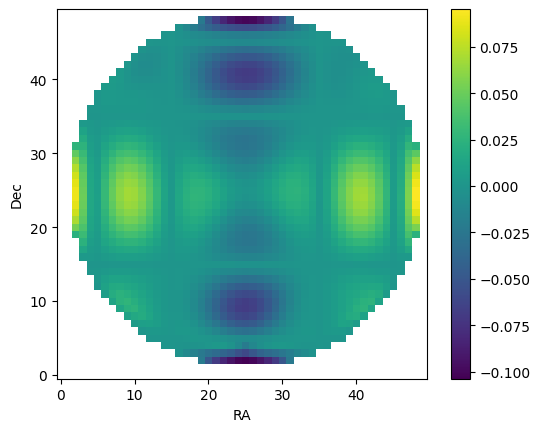

In [7]:
diff = np.abs(all_gx_eb) - np.abs(all_gy_eb)
im = plt.imshow(diff, origin='lower')
plt.colorbar(im)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.show()

## Stokes IQUV recovery

Now test that we can recover Stokes IQUV from a point source.

Make our sky models. We'll make 4 Stokes I models, where each has either I, Q, U, V = 1, and all other Stokes are zero. To make that happen for Q/U, make the component a list type so explicitly set one or the other to zero. This just checks that all the beam is creating XX,XY,YX,YY visibilities that come out with the sign conventions we expect.

In [8]:
make_sky_models(ra0, dec0)

Keep the simulations tiny by making a 3 ant array

In [9]:
np.random.seed(234987)

##make a random array layout. Source is at phase centre, so the visibilities
##should all be full real and just be set by the flux in the sky
num_antennas = 3
east = np.random.uniform(-1000, 1000, num_antennas)
north = np.random.uniform(-1000, 1000, num_antennas)
height = np.zeros(num_antennas)

array = np.empty((num_antennas, 3))
array[:,0] = east
array[:,1] = north
array[:,2] = height

array_name = "eg_array.txt"
np.savetxt(array_name, array)

Right, run the simulations.

In [ ]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "everybeam_OSKAR"

for pol in ['I', 'Q', 'U', 'V']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'
    
    ##The command to run WODEN
    command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
    command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
    command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
    command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
    command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
    command += f'--time_res=2 --num_time_steps=1 --IAU_order '
    command += f' --station_id=0 ' ##default behaviour is to use a different primary beam for each station. All stations are the same here so pick first one.
    command += f'--beam_ms_path=create_OSKAR-MWA_ms/OSKAR-MWA-layout.ms '
    command += '--num_threads=1'
    
    call(command, shell=True)


Note I've deleted the outputs of the cell above, because EveryBeam spits out a bunch of error messages with the `OSKAR` beam warning about frequencies mismatching, and not having a central direction set. The outputs seems fine. It's a TODO to silence these warnings.

Tests are defined in `eb_testing_code.py`, which just asserts that whichever Stokes param we set to one comes out as one, and everything else is zero. Make the absolute tolerance of the test something to toggle, because real beam has leakage, and we don't have the beam at exactly the phase centre for `hyperbeam`. The Stokes recovery is only really legit when the XX and YY beams are the same, so it's good at phase centre and zenith.

In [11]:
for pol in ['I', 'Q', 'U', 'V']:
# for pol in ['I']:
    test_stokes_recovery(pol, 'everybeam_OSKAR', atol=1e-1)
    
    ##Uncomment to print out example values
    
    uvfits_name = f"stokes{pol}_everybeam_OSKAR"
    XX, XY, YX, YY = read_uvfits(f'{uvfits_name}_band01.uvfits')
    ##pick a random baseline to plot, they should all be the sam
    baseline = 0

    recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])
    
    print(f"{pol}, {recover_I[0].real:.2f}, {recover_Q[0].real:.2f}, {recover_U[0].real:.2f}, {recover_V[0].real:.2f}")

Testing Stokes I
Stokes I passed
I, 1.00, 0.00, -0.00, -0.00
Testing Stokes Q
Stokes Q passed
Q, 0.00, 1.00, -0.00, 0.00
Testing Stokes U
Stokes U passed
U, -0.00, 0.00, 1.00, 0.00
Testing Stokes V
Stokes V passed
V, -0.00, -0.00, -0.00, 1.00


## Now test an RM recovery
Check we recover the correct RM and sign for a linearly polarised source. First of all, make the sky model.

In [12]:
phi_RM, pol_frac = make_RM_skymodel(ra0, dec0)

Run that through `WODEN`

In [ ]:
freq_reso = 0.1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)


primary_beam = "everybeam_OSKAR"

uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f' --station_id=0 '
command += f'--beam_ms_path=create_OSKAR-MWA_ms/OSKAR-MWA-layout.ms '
command += '--num_threads=1'

call(command, shell=True)

Note I've deleted the outputs of the cell above, because EveryBeam spits out a bunch of error messages with the `OSKAR` beam warning about frequencies mismatching, and not having a central direction set. The outputs seems fine. It's a TODO to silence these warnings.

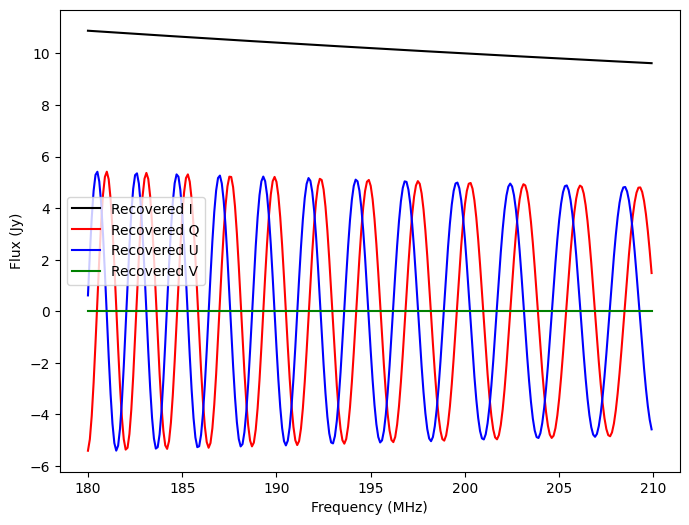

In [14]:
XX, XY, YX, YY = read_uvfits('rm_source_everybeam_OSKAR_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

Righto, because we are normalising to beam centre, and also simulating the point source at beam centre, we get something lovely and perfect.

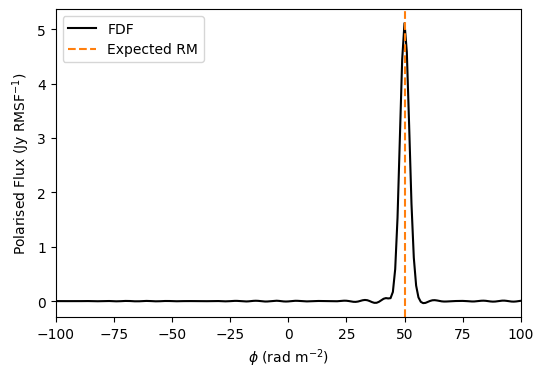

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.5 Expected Pol Fraction 0.5


In [15]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs, atol=1e-2)

Works loverly.

## Test antenna locations

Now check to see if the antenna locations are read in correctly from a measurement set. We'll run `WODEN` using the `metafits` file that was used to make the `OSKAR MWA` measurement set. Then compare that to running the with the same settings but using the `OSKAR MWA` measurement set directly. 

In [16]:
freq_reso = 0.1e+6
low_freq = 180e+6
num_freq_chans = 1

primary_beam = "MWA_FEE"

uvfits_name = f"ant_locs_{primary_beam}"
cat_name = 'RM_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--metafits_filename=../../examples/metafits/1126115208_metafits.fits '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += '--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] '
command += '--num_threads=1'


call(command, shell=True)

/home/jline/software/anaconda3/envs/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.3.0')


You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00455deg -26.70332deg
Obs epoch initial LST was 0.0087300922 deg
Setting initial J2000 LST to 359.6931723607 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
From Set 0 thread num 0 reading 1 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0
Finshed thread 0 in 0.0 seconds
Sending set 0 to GPU
Middle freq is 1.80640000e+08 
HIP needs this printf otherwise it doesnt work
Set 0 has returned from the GPU after 0.5 seconds


0

In [17]:
primary_beam = "everybeam_OSKAR"

uvfits_name = f"ant_locs_{primary_beam}"
cat_name = 'RM_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f' --station_id=0 '
command += f'--beam_ms_path=create_OSKAR-MWA_ms/OSKAR-MWA-layout.ms '
command += '--num_threads=1'

call(command, shell=True)

/home/jline/software/anaconda3/envs/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.3.0')


Successful readonly open of default-locked table create_OSKAR-MWA_ms/OSKAR-MWA-layout.ms/ANTENNA: 8 columns, 128 rows
You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00455deg -26.70332deg
Obs epoch initial LST was 0.0087300922 deg
Setting initial J2000 LST to 359.6931723607 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
From Set 0 thread num 0 reading 1 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0
OSKAR response model skala40_wave
Could not load dataset for frequency 180 MHz, using the nearest neighbor with frequenc

0

Read in the XYZ positions from the resultant `uvfits` files, as well as the `uvw` coordinates.

In [18]:
def read_xyz_uvfits(uvfits_name):
    
    with fits.open(uvfits_name) as hdu:
        xyz = hdu[1].data['STABXYZ']
        uu = hdu[0].data['UU']*C
        vv = hdu[0].data['VV']*C
        ww = hdu[0].data['WW']*C
        
    return xyz, uu, vv, ww


In [19]:
xyz_meta, uu_meta, vv_meta, ww_meta = read_xyz_uvfits('ant_locs_MWA_FEE_band01.uvfits')
xyz_ms, uu_ms, vv_ms, ww_ms = read_xyz_uvfits('ant_locs_everybeam_OSKAR_band01.uvfits')

First up compare the XYZ coords

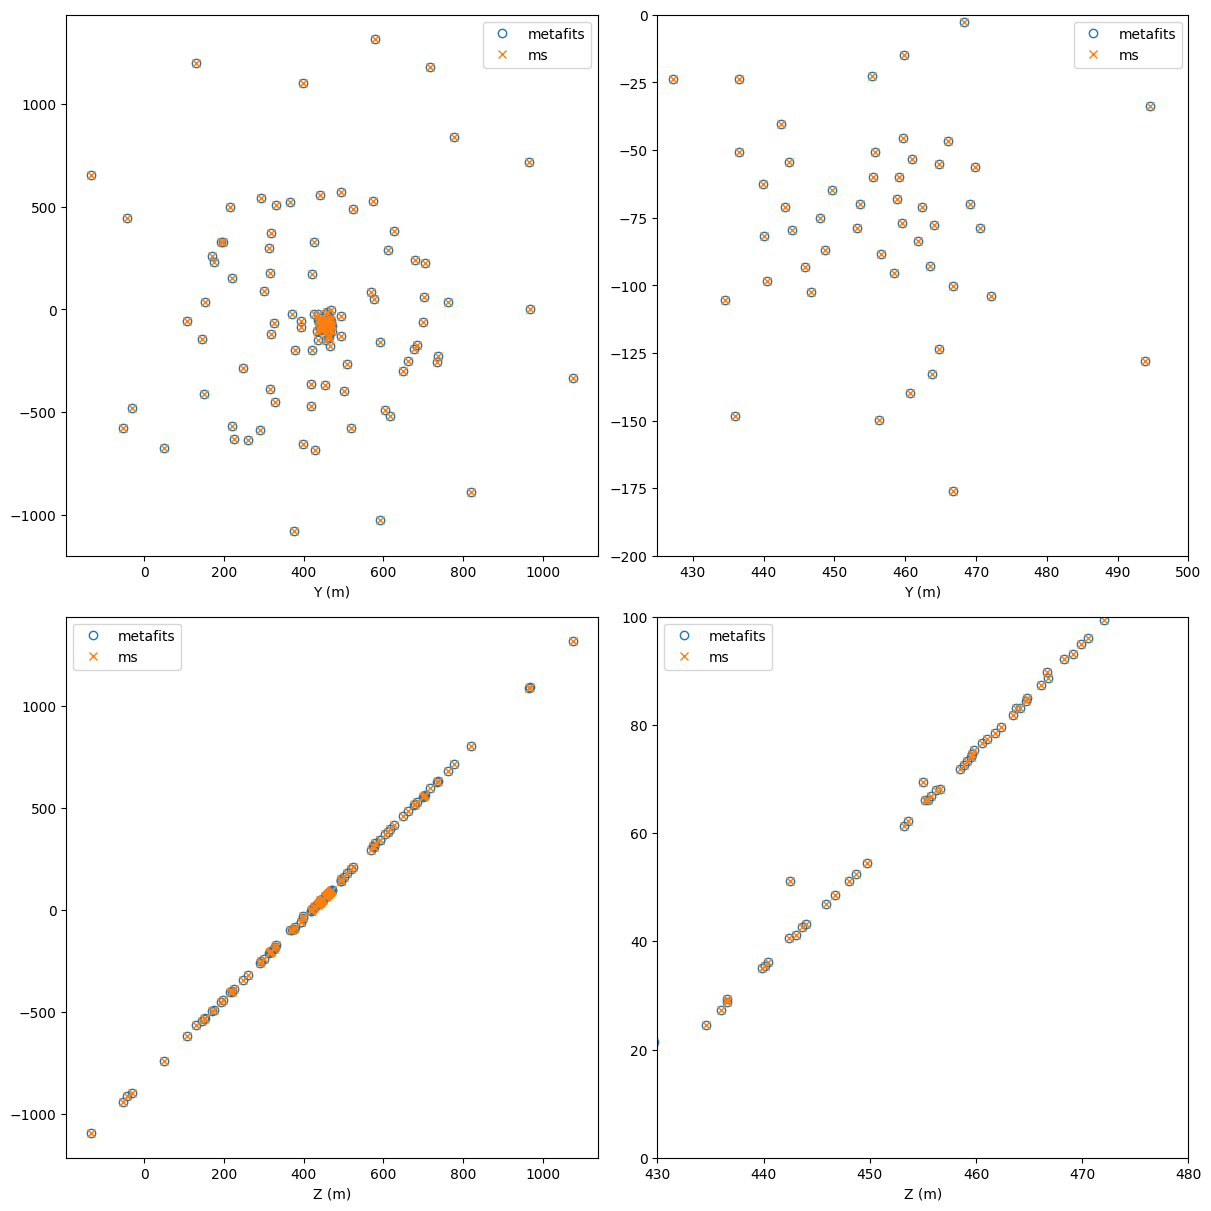

In [20]:
def plot(xyz, ax1, ax2, marker, label):
        
        ax1.plot(xyz[:,0], xyz[:,1], marker, mfc='none', label=label)
        ax2.plot(xyz[:,0], xyz[:,2], marker, mfc='none', label=label)
        
        
fig, axs = plt.subplots(2, 2, figsize=(12, 12), layout='constrained')

plot(xyz_meta, axs[0,0], axs[1,0], 'o', 'metafits')
plot(xyz_ms, axs[0,0], axs[1,0], 'x', 'ms')

plot(xyz_meta, axs[0,1], axs[1,1], 'o', 'metafits')
plot(xyz_ms, axs[0,1], axs[1,1], 'x', 'ms')

axs[0,1].set_xlim(425, 500)
axs[0,1].set_ylim(-200, 0)

axs[1,1].set_xlim(430, 480)
axs[1,1].set_ylim(0, 100)

for ax in axs.flatten():
    ax.legend()
    
axs[0,0].set_xlabel('X (m)')
axs[0,0].set_xlabel('Y (m)')
axs[0,1].set_xlabel('X (m)')
axs[0,1].set_xlabel('Y (m)')

axs[1,0].set_xlabel('X (m)')
axs[1,0].set_xlabel('Z (m)')
axs[1,1].set_xlabel('X (m)')
axs[1,1].set_xlabel('Z (m)')

plt.show()

In [21]:
np.allclose(xyz_meta, xyz_ms, atol=1e-3, rtol=1e-6)

True

Now compare the `uv` coords. 

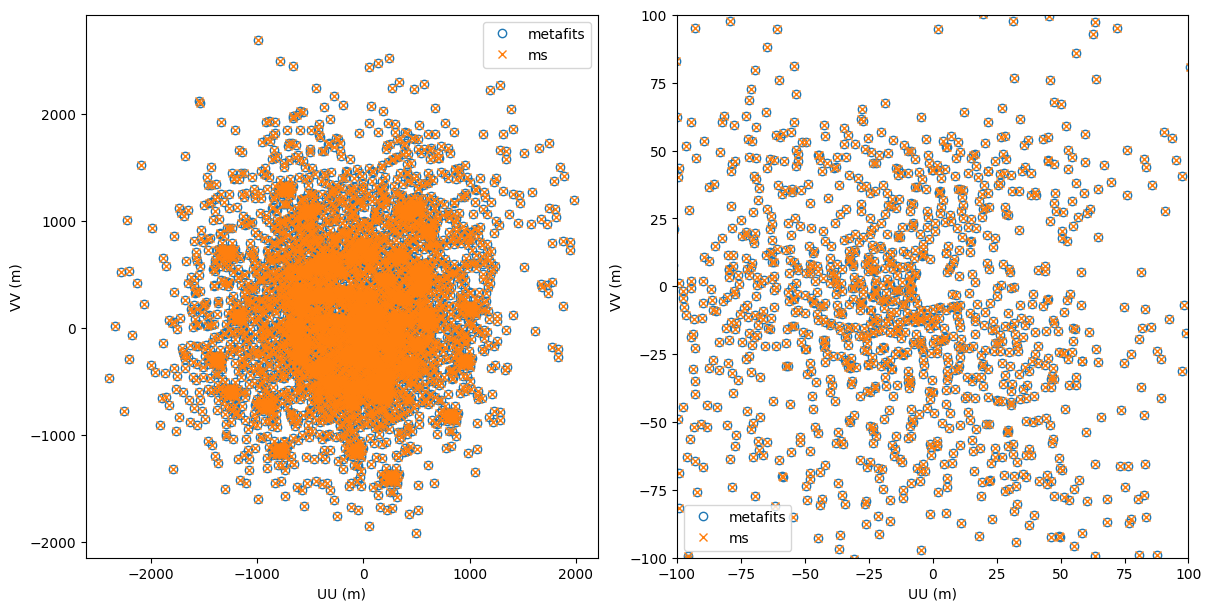

In [22]:
        
fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout='constrained')

for ax in axs:

    ax.plot(uu_meta, vv_meta, 'C0o', mfc='none', label='metafits')
    # ax.plot(-uu_meta, -vv_meta, 'C0o', mfc='none')

    ax.plot(uu_ms, vv_ms, 'C1x', mfc='none', label='ms')
    # ax.plot(-uu_ms, -vv_ms, 'C1x', mfc='none')
    
    ax.set_xlabel('UU (m)')
    ax.set_ylabel('VV (m)')
    
    ax.legend()
        
axs[1].set_xlim(-100, 100)
axs[1].set_ylim(-100, 100)

plt.show()

In [23]:
print(f"u coords max, mean diff {np.max(np.abs(uu_meta - uu_ms)):.2e}, {np.mean(np.abs(uu_meta - uu_ms)):.2e} (metres)")
print(f"v coords max, mean diff {np.max(np.abs(vv_meta - vv_ms)):.2e}, {np.mean(np.abs(vv_meta - vv_ms)):.2e} (metres)")
print(f"w coords max, mean diff {np.max(np.abs(ww_meta - ww_ms)):.2e}, {np.mean(np.abs(ww_meta - ww_ms)):.2e} (metres)")

u coords max, mean diff 5.96e-08, 7.33e-12 (metres)
v coords max, mean diff 0.00e+00, 0.00e+00 (metres)
w coords max, mean diff 4.77e-07, 2.28e-10 (metres)


OK, so this is interesting. In `test_MWA.ipynb` (in the same directory as this notebook), we see that the `uv` coords are the same, but the `XYZ` coords are offset. That was after reading in antenna locations from a `hyperbeam` measurement set. `OSKAR` doesn't do precession, and I write out the current XYZ to the `uvfits`. Maybe `hyperbeam` writes out the precessed XYZ? I don't *think* this is a problem, as the `uv` coords are the same, and all software I know of / care about reads the `uvw` not the `XYZ`. But it's worth noting. 

## Let's see if we can make flagged dipole beams

Again, I've used `OSKAR` to make a measurement set via `create_OSKAR-MWA_ms/make_oskar-mwa_beam.ipynb`. This time I've made the first 16 tiles have a flagged dipole each; this should give us visible beam shape deformities. First plot them on the sky to check we are getting the right thing. Then we'll look inside the visibilities for a single off-zenith point source as different beams means the amplitudes of the visis should vary. We'll also do two time steps, and two frequencies, to check we're calling the right beam for the right time/frequency.

In [44]:
##Setup a grid of RA/Dec on the sky
nside=64
radec_reso = 120/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = np.radians(ras.flatten())
decs = np.radians(decs.flatten())

num_comps = len(ras)

all_freqs = np.array([160e+6, 230e+6])
all_times = np.array([observing_time, observing_time + TimeDelta(3*3600.0, format='sec')])
num_beams = 1
station_ids = np.arange(16)

lsts = []
latitudes = []

for obs_time in all_times:
    
    LST = obs_time.sidereal_time('mean')
    lst_current = np.radians(LST.value*15)
    
    lst_J2000, latitude_J2000 = RTS_Precess_LST_Lat_to_J2000(
                                lst_current,
                                np.radians(MWA_LAT),
                                obs_time.mjd)
    
    lsts.append(lst_J2000)
    latitudes.append(latitude_J2000)

coeff_path=""
ms_path="create_OSKAR-MWA_ms/OSKAR-MWA-flags-layout.ms"
use_differential_beam=False
apply_beam_norms = True
reorder_jones = False
parallactic_rotate = False
eb_rotate = True
element_response = "skala40_wave"

num_threads = 8

all_jones = run_everybeam_over_threads(num_threads, ms_path,
                            coeff_path,
                            ras, decs,
                            np.radians(ra0), np.radians(dec0),
                            latitudes, lsts,
                            np.radians(MWA_LAT), np.radians(MWA_LONG),
                            all_times, all_freqs, station_ids,
                            use_differential_beam=use_differential_beam,
                            apply_beam_norms=apply_beam_norms,
                            reorder_jones=reorder_jones,
                            parallactic_rotate=parallactic_rotate,
                            eb_rotate=eb_rotate,
                            element_response_model=element_response)

Thread 1 processing coords 512 to 1024Thread 5 processing coords 2560 to 3072

Thread 2 processing coords 1024 to 1536Thread 6 processing coords 3072 to 3584

Thread 4 processing coords 2048 to 2560Thread 0 processing coords 0 to 512

Thread 7 processing coords 3584 to 4096Thread 3 processing coords 1536 to 2048



/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:4642: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:4642: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:19026: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:19026: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:4642: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:4642: RuntimeWarning: invalid

Thread 1 finished
Thread 0 finished
Thread 3 finished
Thread 4 finished
Thread 5 finished
Thread 2 finished
Thread 6 finished
Thread 7 finished


Ah man, note that this takes nearly an hour on my deskop, even spread across 8 threads. Really need to take advantage of the fact we can do the array pattern separately to the element response for each direction; that should reduce the amount of operations.

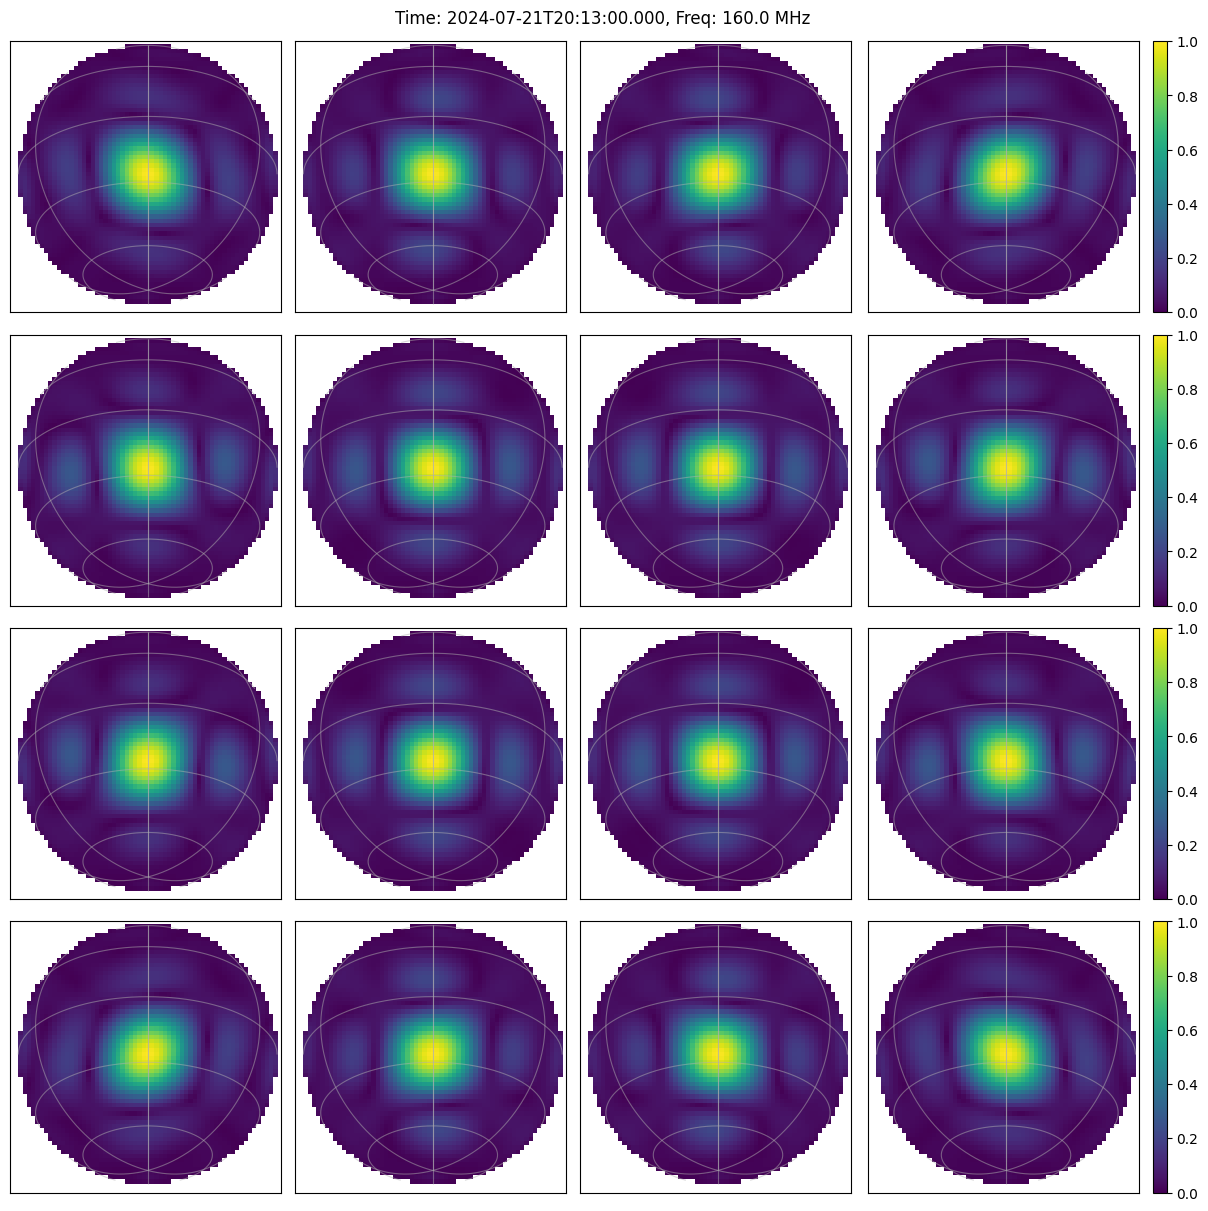

In [45]:
def plot_beam_selection(all_jones, time_ind, freq_ind, nside, wcs):
    fig, axs = plt.subplots(4, 4, figsize=(12, 12), layout='constrained',
                            subplot_kw={'projection': wcs})
    
    for col in range(4):
        for row in range(4):
            beam_ind = col*4 + row
            
            gx = all_jones[beam_ind, time_ind, freq_ind, :, 0,0]
            gx.shape = (nside, nside)
            
            im = axs[row, col].imshow(np.abs(gx), origin='lower', vmax=1, vmin=0)
            
            axs[row, col].grid(alpha=0.5)
            
            lon = axs[row, col].coords[0]
            lat = axs[row, col].coords[1]
            
            lon.set_ticks_visible(False)
            lat.set_ticks_visible(False)
            lon.set_axislabel(' ')
            lat.set_axislabel(' ')
            
            if col > 0:
                lat.set_ticklabel_visible(False)
            if row < 3:
                lon.set_ticklabel_visible(False)
                
            if col == 3:
                plt.colorbar(im, ax=axs[row, col])
            

    fig.suptitle(f"Time: {all_times[time_ind].isot}, Freq: {all_freqs[freq_ind]/1e+6} MHz")

    plt.show()

time_ind = 0
freq_ind = 0
plot_beam_selection(all_jones, time_ind, freq_ind, nside, wcs)

Great success, we can see our beams are deformed in different ways for the first 16 dipoles. Let's try a different frequency:

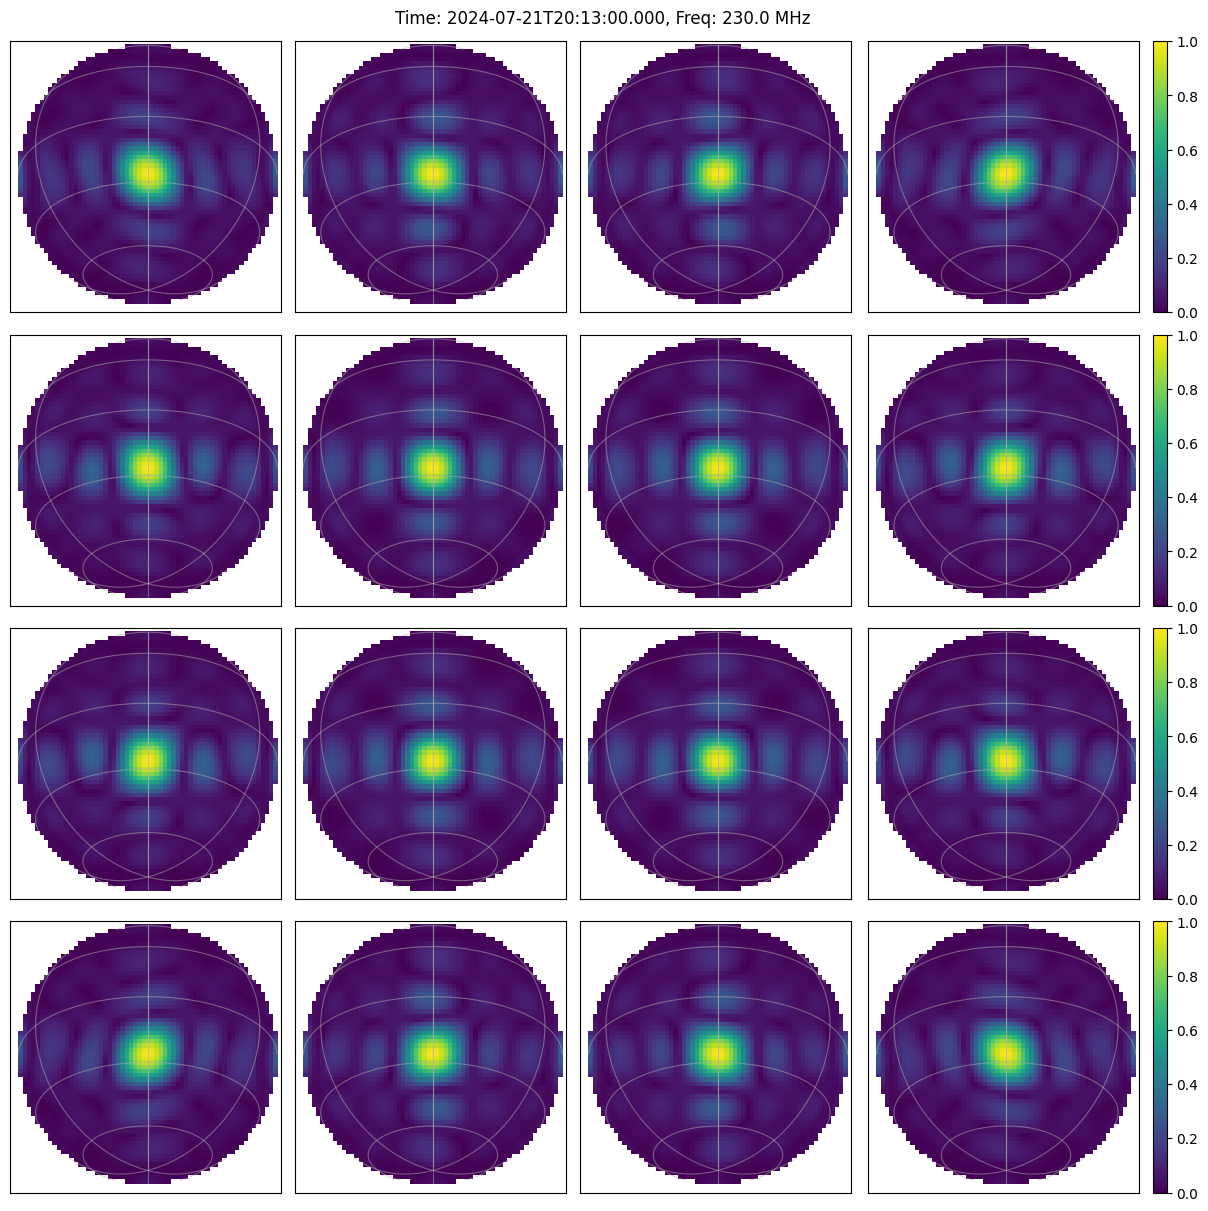

In [46]:
time_ind = 0
freq_ind = 1
plot_beam_selection(all_jones, time_ind, freq_ind, nside, wcs)

Now we'll try 3 hours later in time:

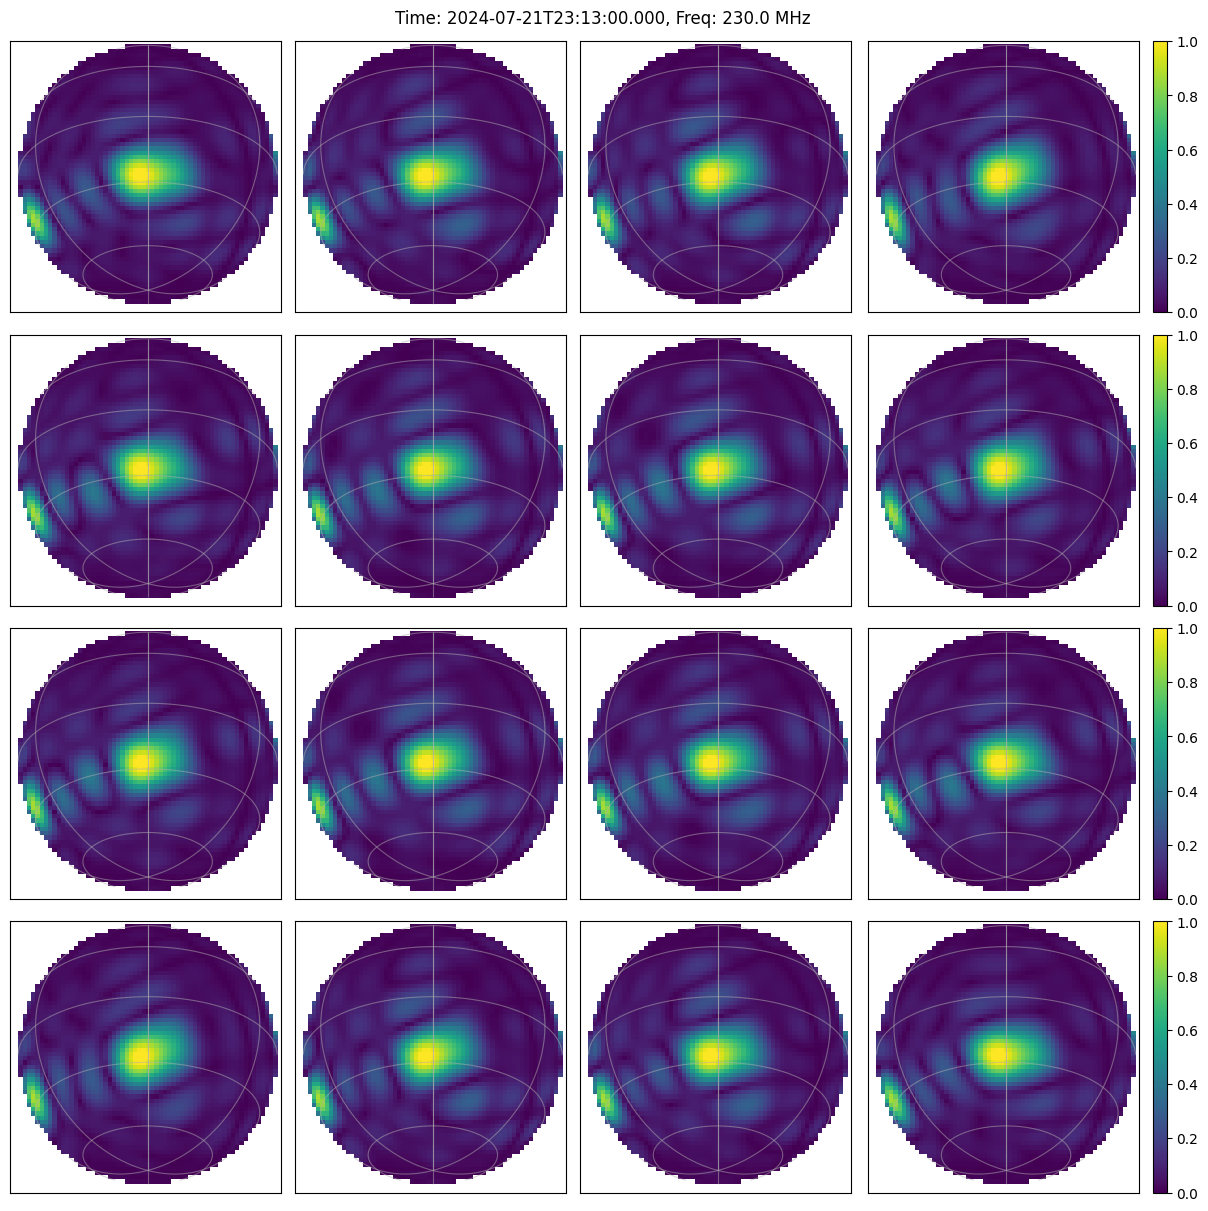

In [47]:
time_ind = 1
freq_ind = 1
plot_beam_selection(all_jones, time_ind, freq_ind, nside, wcs)

OK, this looks really weird with a second beam maximum not being at phase centre. But we can get the same thing using `hyperbeam`; it's just a phased array MWA thing.

In [48]:
##Then use erfa to convert these values into azs, els
has = lsts[1] - ras

##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here
az_grid, els = erfa.hd2ae(has, decs, np.radians(MWA_LAT))

za_grid = np.pi/2 - els

beam = mwa_hyperbeam.FEEBeam()

freq = 230e+6

delays = [4, 8, 12, 16]*4

jones = beam.calc_jones_array(az_grid, za_grid, freq, delays, [1]*16, True, np.radians(MWA_LAT), True)

/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


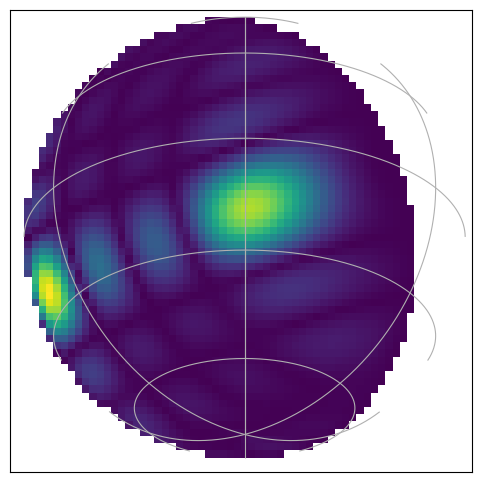

In [49]:
all_gx = jones[:,0]

all_gx = np.abs(all_gx).reshape(nside, nside)

mask = np.ones((nside, nside))
mask[els.reshape(nside, nside) < 0] = np.nan 

fig, axs = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={'projection': wcs})

axs.grid()

axs.imshow(all_gx*mask, origin='lower')

plt.show()

Now let's check the visibilities. First of all, we'll check all the visis are the same when we use the same primary beam for all tiles. Then we'll play with the flagged tiles to see what happens

In [34]:

##make some more single point source sky models, but this time for an offzenith source
make_sky_models(ra0 + 15, dec0)

In [ ]:
freq_reso = 40e+3
low_freq = 160e+6
num_freq_chans = 2

primary_beam = "everybeam_OSKAR"

uvfits_name = f"noflag_{primary_beam}"
cat_name = 'I_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f'--station_id=20 '
command += f'--beam_ms_path=create_OSKAR-MWA_ms/OSKAR-MWA-flags-layout.ms '
command += '--num_threads=1'

call(command, shell=True)

/home/jline/software/anaconda3/envs/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.3.0')


Successful readonly open of default-locked table create_OSKAR-MWA_ms/OSKAR-MWA-flags-layout.ms/ANTENNA: 8 columns, 128 rows
You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00455deg -26.70332deg
Obs epoch initial LST was 0.0087300922 deg
Setting initial J2000 LST to 359.6931723607 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
From Set 0 thread num 0 reading 1 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0
OSKAR response model skala40_wave
OSKAR has no preapplied beam direction (yet). preapplied_beam_dir is equal to th

0

Read in the visibilities and plot the amplitudes of the first freq

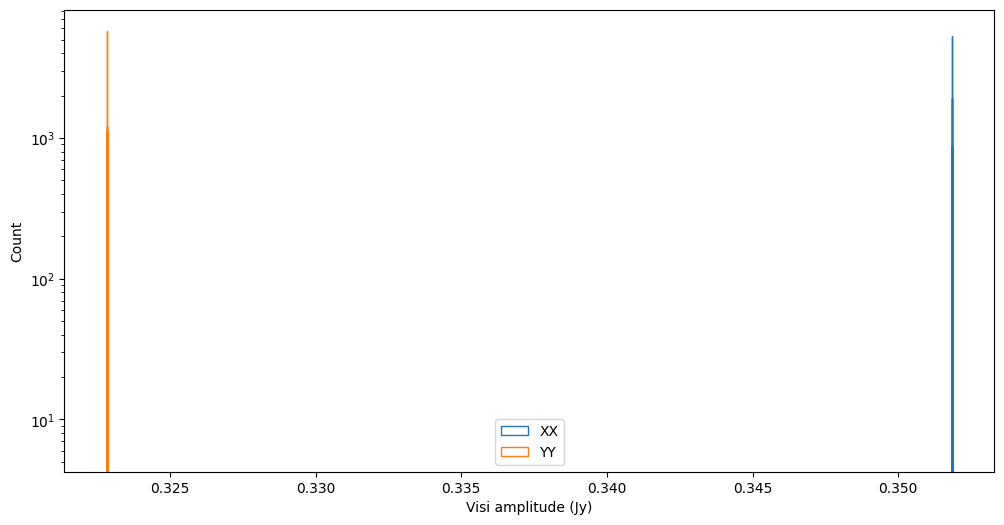

In [36]:
XX, XY, YX, YY = read_uvfits('noflag_everybeam_OSKAR_band01.uvfits')

##take the XX and YY for the first freq and do some histograms


fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.hist(np.abs(XX[:, 0]), bins=100, histtype='step', color='C0', label='XX')
axs.hist(np.abs(YY[:, 0]), bins=100, histtype='step', color='C1', label='YY')

xx_noflag_osk = np.mean(np.abs(XX[:, 0]))
yy_noflag_osk = np.mean(np.abs(YY[:, 0]))

axs.set_xlabel('Visi amplitude (Jy)')
axs.set_ylabel('Count')

axs.set_yscale('log')

axs.legend()

plt.show()

As expected, the XX and YY have different amplitudes, but all visibilities are the same. Now let's check the flagged tiles. First we'll estimate how many visibilities should be different, given only the first 16 tiles have different beams.

In [37]:
unchanged = 0
num_ants = 128

num_baseline = 0

first_unchanged = np.nan


for i in range(num_ants - 1):
    for j in range(i+1, num_ants):
        if i > 15 and j > 15:
            
            if np.isnan(first_unchanged):
                first_unchanged = num_baseline
            
            unchanged += 1
        num_baseline += 1
    
print(f"Percentage of expected unchanged baselines: {unchanged} / {num_baseline} = {unchanged/num_baseline*100:.2f}%")
print(f"First unchanged baseline: {first_unchanged}")

Percentage of expected unchanged baselines: 6216 / 8128 = 76.48%
First unchanged baseline: 1912


In [ ]:

##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 40e+3
low_freq = 160e+6
num_freq_chans = 2

primary_beam = "everybeam_OSKAR"

uvfits_name = f"flagged_{primary_beam}"
cat_name = 'I_source.fits'

print(ra0, dec0)

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f'--beam_ms_path=create_OSKAR-MWA_ms/OSKAR-MWA-flags-layout.ms '
command += '--num_threads=1'

call(command, shell=True)

Note I've deleted the outputs of the cell above, because EveryBeam spits out a bunch of error messages with the `OSKAR` beam warning about frequencies mismatching, and not having a central direction set. The outputs seems fine. It's a TODO to silence these warnings.

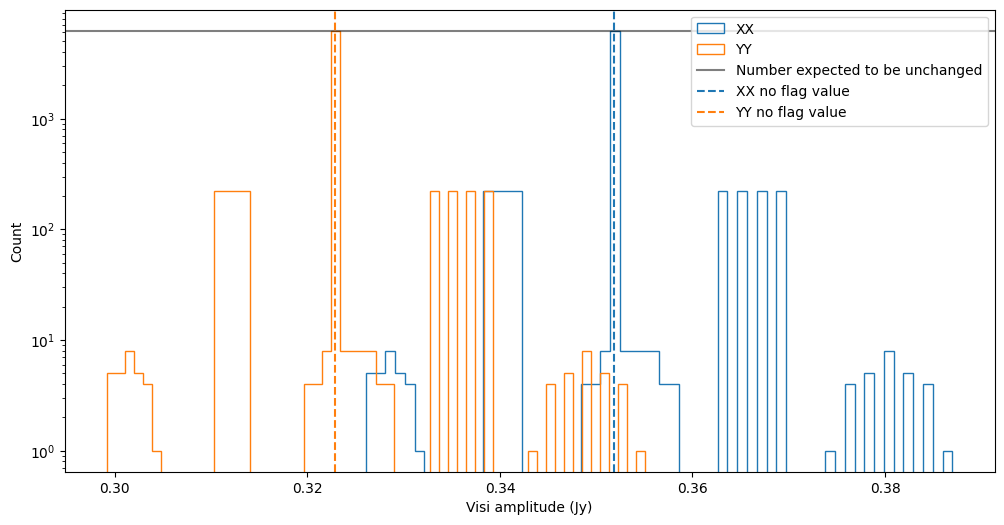

In [39]:
XX, XY, YX, YY = read_uvfits('flagged_everybeam_OSKAR_band01.uvfits')

##take the XX and YY for the first freq and do some histograms


fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.hist(np.abs(XX[:, 0]), bins=60, histtype='step', color='C0', label='XX')
axs.hist(np.abs(YY[:, 0]), bins=60, histtype='step', color='C1', label='YY')

axs.axhline(unchanged, color='k', linestyle='-', alpha=0.5, label='Number expected to be unchanged')


axs.axvline(xx_noflag_osk, color='C0', linestyle='--', label='XX no flag value')
axs.axvline(yy_noflag_osk, color='C1', linestyle='--', label='YY no flag value')


axs.set_xlabel('Visi amplitude (Jy)')
axs.set_ylabel('Count')

axs.set_yscale('log')

axs.legend()

plt.show()

OK, this makes sense. I only put dipole flags on the first 16 tiles, so a large number of the visibilities should have the same value (which are the big central peaks of each distribution). The XX and YY are different amplitudes, as I put the source on the meridian. This means the XX and YY beams should have different sensitivities. They both have the same dipole flags however, so the distributions should have a similar shape as they do.

Maybe counter-intuitive, but with the change in beam shape per tiles, some beams can become relatively more sensitive than others. As I'm normalising each beam individually towards the phase centre, this means we can high a higher ampltiude than the full 16 dipole beam. This behaviour probably needs to be changed to have some kind of overall normalisation, but this is a good first step.

Let's compare that to a `hyperbeam` model with the same flags



In [40]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 40e+3
low_freq = 160e+6
num_freq_chans = 2

primary_beam = "MWA_FEE"

uvfits_name = f"noflags_{primary_beam}"
cat_name = 'I_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f'--metafits=create_OSKAR-MWA_ms/1088285600_flags.metafits '
command += f'--num_threads=1'

call(command, shell=True)

/home/jline/software/anaconda3/envs/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.3.0')


You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00455deg -26.70332deg
Obs epoch initial LST was 0.0087300922 deg
Setting initial J2000 LST to 359.6931723607 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
From Set 0 thread num 0 reading 1 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0
Finshed thread 0 in 0.0 seconds
Sending set 0 to GPU
Middle freq is 1.60640000e+08 
HIP needs this printf otherwise it doesnt work
Set 0 has returned from the GPU after 0.5 seconds


0

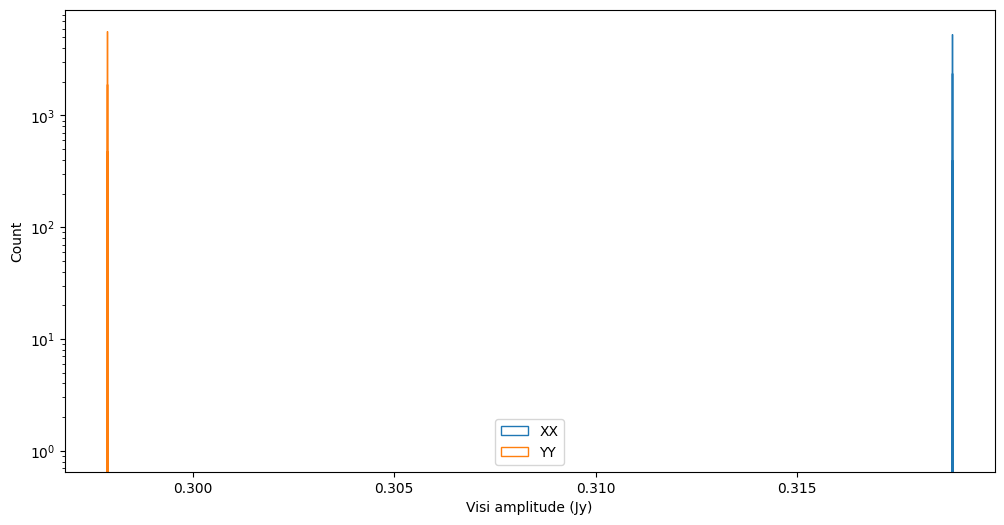

In [41]:

XX, XY, YX, YY = read_uvfits('noflags_MWA_FEE_band01.uvfits')

##take the XX and YY for the first freq and do some histograms


fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.hist(np.abs(XX[:, 0]), bins=100, histtype='step', color='C0', label='XX')
axs.hist(np.abs(YY[:, 0]), bins=100, histtype='step', color='C1', label='YY')

xx_noflag = np.mean(np.abs(XX[:, 0]))
yy_noflag = np.mean(np.abs(YY[:, 0]))

axs.set_xlabel('Visi amplitude (Jy)')
axs.set_ylabel('Count')

axs.set_yscale('log')

axs.legend()

plt.show()

In [42]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 70e+6
low_freq = 160e+6
num_freq_chans = 2

primary_beam = "MWA_FEE"

uvfits_name = f"flagged_{primary_beam}"
cat_name = 'I_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f'--metafits=create_OSKAR-MWA_ms/1088285600_flags.metafits '
command += f'--use_MWA_dipflags '
command += f'--num_threads=1'

call(command, shell=True)

/home/jline/software/anaconda3/envs/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.3.0')


Num tiles with dipole flags: 16
You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00455deg -26.70332deg
Obs epoch initial LST was 0.0087300922 deg
Setting initial J2000 LST to 359.6931723607 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
From Set 0 thread num 0 reading 1 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0
Finshed thread 0 in 0.0 seconds
Sending set 0 to GPU
Middle freq is 1.60640000e+08 
Set 0 has returned from the GPU after 0.7 seconds


0

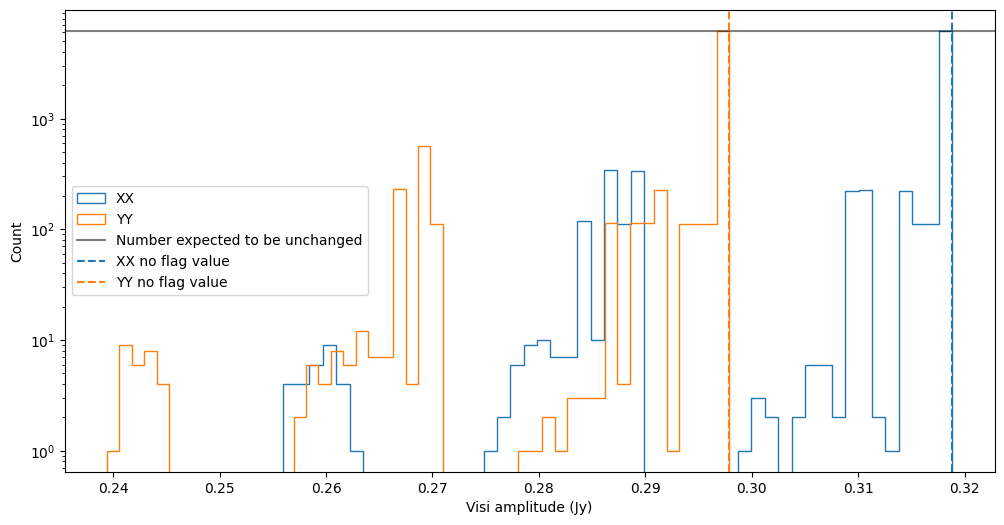

In [43]:
XX, XY, YX, YY = read_uvfits('flagged_MWA_FEE_band01.uvfits')

##take the XX and YY for the first freq and do some histograms


fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.hist(np.abs(XX[:, 0]), bins=50, histtype='step', color='C0', label='XX')
axs.hist(np.abs(YY[:, 0]), bins=50, histtype='step', color='C1', label='YY')

axs.axhline(unchanged, color='k', linestyle='-', alpha=0.5, label='Number expected to be unchanged')


axs.axvline(xx_noflag, color='C0', linestyle='--', label='XX no flag value')
axs.axvline(yy_noflag, color='C1', linestyle='--', label='YY no flag value')


axs.set_xlabel('Visi amplitude (Jy)')
axs.set_ylabel('Count')

axs.set_yscale('log')

axs.legend()

plt.show()

So a similar result to the `everybeam` experiment, with two important differences. Firstly, the `hyperbeam` model is normalised to the full 16 dipole beam, so any dipole flag causes a drop in sensitivity. Hence all visibilities are wither unchanged, or lower than full 16 dipole beam. Secondly, the `XX` and `YY` amps have a slightly different shape. Maybe this has something to do with the different models having different mutual coupling effects, as well as the SKA beam is a christmas tree whereas the MWA dipole is a bowtie.